## LA's COVID-19 Reopening Indicators 
This report contains information about how LA County and the City of LA performed yesterday, on a number of key COVID-19 indicators related to the speed at which opening up can occur. Taken together, performing well against the benchmarks provide confidence in moving through each phase of reopening. 

**LA is certainly an epicenter. In late June, LA County Department of Public Health (DPH) [estimated that 1 in 400 people were infectious](https://www.latimes.com/california/story/2020-06-29/o-c-reports-highest-weekly-covid-19-death-toll-as-california-sees-spike-in-cases), asymptomatic, and not isolated. One week later, as of June 29, LA DPH estimated the risk increased threefold, up to [1 in 140](https://www.nytimes.com/2020/06/29/us/california-coronavirus-reopening.html).** LA County is [projected](https://www.planetizen.com/news/2020/07/109756-californias-coronavirus-infections-and-hospitalizations-surge) to [run out](https://www.latimes.com/california/story/2020-06-29/l-a-county-issues-dire-warning-amid-alarming-increases-in-coronavirus) of ICU beds by early to mid July, with acute care beds [reaching capacity](https://www.nytimes.com/2020/07/03/health/coronavirus-mortality-testing.html) soon after. **LA reaches [5,000 deaths](https://www.latimes.com/california/story/2020-08-11/13000-more-coronavirus-cases-california-test-results-backlog) by mid-August, and is ranked as 3rd highest US county in terms of deaths**, after Queens (NY) and Kings (NY) Counties.

As long as LA consistently tests large portions of its population with fairly low positive COVID-19 results, sustains decreases in cases and deaths, has stable or decreasing COVID-related hospitalizations, and stocks ample available hospital equipment for a potential surge, we are positioned to continue loosening restrictions. When any one indicator fails to meet the benchmark, we should slow down to consider why that is happening. When multiple indicators fail to meet the benchmark, we should pause our reopening plans and even enact more stringent physical and social distancing protocols by moving back a phase.     
    
* [Federal Gating Criteria](https://www.whitehouse.gov/wp-content/uploads/2020/04/Guidelines-for-Opening-Up-America-Again.pdf)
* [State Gating Criteria](https://covid19.ca.gov/roadmap-counties/)
    * CA Department of Public Health's [Blueprint](https://covid19.ca.gov/safer-economy/#reopening-data) toward Reopening, [rules for tier assignments](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) and [Dimmer Switch Framework](https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Dimmer-Framework-August_2020.pdf)
    * [CA Reopening, Take 2](https://www.nytimes.com/2020/08/31/us/california-coronavirus-reopening.html)
* [WHO Testing and Positivity Rate Guidelines](https://coronavirus.jhu.edu/testing/testing-positivity)

Below, you will see how LA performed yesterday on the following indicators. The data does have a one day lag. Whenever City of LA (subset of LA County) data is available, it is also reported.

#### Symptoms
* Downward trajectory of influenza-like illnesses (ILI) reported within a 14-day period **and**
* Downward trajectory of COVID-like syndromic cases reported within a 14-day period

#### Cases
* Downward trajectory of documented cases within a 14-day period **or**
* Downward trajectory of positive tests as a percent of total tests within a 14-day period (flat or increasing volume of tests) 

#### Hospitals
* Treat all patients without crisis care **and**
* Robust testing program in place for at-risk healthcare workers, including emerging antibody testing

### References
* [Reopening Indicators](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/Reopening_Indicators_Comparison.xlsx) from [New York State](https://www.nytimes.com/2020/05/04/nyregion/coronavirus-reopen-cuomo-ny.html) and [Chicago](https://www.chicagotribune.com/coronavirus/ct-coronavirus-chicago-reopening-lightfoot-20200508-ztpnouwexrcvfdfcr2yccbc53a-story.html)
* [Collection of articles](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md) related to what experts say about reopening and the known unknowns ahead 
    * [LA and Chicago](https://www.nytimes.com/2020/05/09/us/coronavirus-chicago.html), after NYC, have the most persistent virus caseloads
    * [LA, DC, and Chicago](https://www.latimes.com/california/story/2020-05-22/white-house-concerned-with-coronavirus-spread-in-l-a-area-asks-cdc-to-investigate) remain hotspots within the US 

In [1]:
import numpy as np
import pandas as pd

import utils
import default_parameters
import make_charts
import meet_indicators
import ca_reopening_tiers

from IPython.display import display_html, Markdown, HTML

# Default parameters
county_state_name = default_parameters.county_state_name
state_name = default_parameters.state_name
msa_name = default_parameters.msa_name
time_zone = default_parameters.time_zone

fulldate_format = default_parameters.fulldate_format
monthdate_format = default_parameters.monthdate_format
start_date = default_parameters.start_date
yesterday_date = default_parameters.yesterday_date
today_date = default_parameters.today_date
one_week_ago = default_parameters.one_week_ago
two_weeks_ago = default_parameters.two_weeks_ago
three_weeks_ago = default_parameters.three_weeks_ago
two_days_ago = default_parameters.two_days_ago
eight_days_ago = default_parameters.eight_days_ago

# Daily testing upper and lower bound
county_test_lower_bound = 15_000
county_test_upper_bound = 16_667
positive_lower_bound = 0.04
positive_upper_bound = 0.08
positive_2weeks_bound = 0.05
hospital_bound = 0.30
ca_hospitalization_bound = 0.05

# Set cut-offs for CA reopening
ca_case_minimal_bound = 1
ca_case_moderate_bound = 4
ca_case_substantial_bound = 7 
ca_test_minimal_bound = 0.020
ca_test_moderate_bound = 0.050
ca_test_substantial_bound = 0.080

#### Indicators Based on CA State Guidelines
CA's [Blueprint for a Safer Economy](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) assigns each county to a tier based on case rate and test positivity rate. If counties fall into 2 different tiers on the two metrics, they are assigned to the more restrictive tier. Tiers, from most severe to least severe, categorizes coronavirus spread as <strong><span style='color:#6B1F84'>widespread; </span></strong>
<strong><span style='color:#F3324C'>substantial; </span></strong><strong><span style='color:#F7AE1D'>moderate; </span></strong><strong><span style = 'color:#D0E700'>or minimal.</span></strong>
**Counties must stay in the current tier for 3 consecutive weeks and metrics from the last 2 consecutive weeks must fall into less restrictive tier before moving into a less restrictive tier.**

* **Case Rate per 100k**: the unadjusted case rate per 100k. <span style = 'color:#6B1F84'>Any value above 7 is widespread; </span><span style = 'color:#F3324C'>a value of 4-7 is substantial. </span> CA does adjust the case rate based on testing volume, but that is not done here.

* **Test Positivity Rate**: percent of tests that are COVID-positive. <span style = 'color:#6B1F84'>Any value above 8% is widespread; </span><span style = 'color:#F3324C'>a value of 5-8% is substantial. </span> 

#### Indicators Based on Federal Guidelines
These indicators can <strong><span style='color:#F3324C'>fail to meet the lower benchmark; </span></strong><strong><span style='color:#10DE7A'>meet the lower benchmark; </span></strong>
<strong><span style = 'color:#1696D2'>or exceed the higher benchmark.</span></strong>

* **Cases and deaths**: the number of days with declining values from the prior day over the past 14 days. Guidelines state both should sustain a 14-day downward trajectory. <span style = 'color:red'>Any value less than 14 means we failed to meet this benchmark.</span>

* **Daily Testing**: number of daily tests conducted for the county 2 days ago (accounting for a time lag in results reported). LA County's goal is to test 15,000 daily (45 tests per 1,000 residents) *(lower bound)*. Chicago's goal was 50 tests per 1,000 residents, translating to 16,667 tests daily *(upper bound)*. 
<span style = 'color:red'>Below 15,000 (county) means we failed this benchmark.</span>

* **Positive Tests**: proportion of positive tests last week, values fall between 0 and 1. CA's positivity requirement is 8% or below *(upper bound)*, but experts say that [less than 4%](https://www.nytimes.com/2020/05/25/health/coronavirus-testing-trump.html) is necessary to halt the spread of the virus *(lower bound)*. 
<span style = 'color:red'>More than 8% positive for the past week means we failed to meet this benchmark.</span> 

* **Positive Tests (WHO)**: proportion of positive tests in the past 2 weeks, values fall between 0 and 1. The weeks are weighted by the number of tests conducted. The WHO recommends that tests return less than 5% positive for 14 days prior to reopening. JHU has a [state-by-state analysis](https://coronavirus.jhu.edu/testing/testing-positivity) of this. 
<span style = 'color:red'>More than 5% positive over two weeks means we failed to meet this benchmark.</span> 

* **Hospitalizations**: the 7-day averaged daily percent change in all COVID hospitalizations and COVID ICU hospitalizations; values fall between 0 and 1. CA guidelines ask for stable or downward trends, not exceeding a 5% daily change.
<span style = 'color:red'>Above 5% means we failed to meet this benchmark.</span>

In [2]:
display(Markdown("## Caseload Charts"))
display(Markdown(
    f"These are the trends in cases and deaths for the county and the city since {start_date.strftime(fulldate_format)}, using a 7-day rolling average. "
    )
)

## Caseload Charts

These are the trends in cases and deaths for the county and the city since 4/15/20, using a 7-day rolling average. 

The **cases and deaths requirement is that both have been decreasing for the past 14 days.** The past 14 days are shaded in gray.

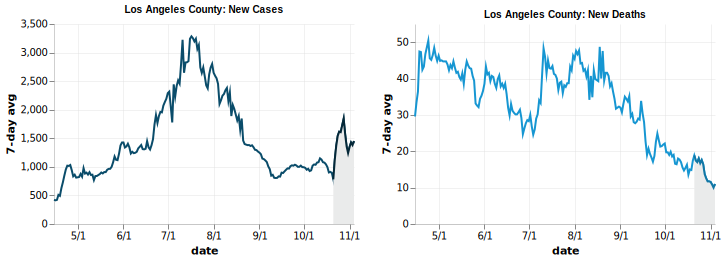

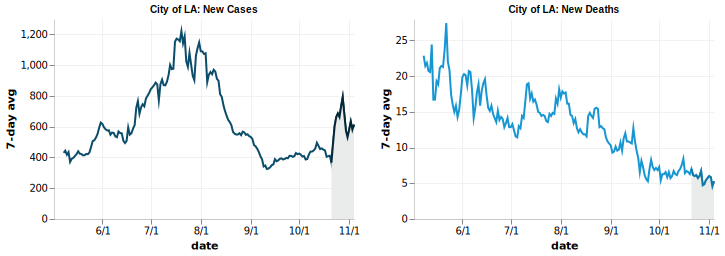

In [3]:
la_county = utils.county_case_charts(county_state_name, start_date)

In [ ]:
print("Charts ran")